In [1]:
# from __future__ import division
import itertools

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import seaborn as sns

import numpy as np
import pandas as pd

import math
from sklearn import metrics
from random import randint

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

import env
from env import host, user, password

In [2]:
#defines function to create a sql url using personal credentials
def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

### 1. Use DBSCAN to detect anomalies in other products from the customers dataset.

In [3]:
#get connection by saving to a variable
url = get_connection("grocery_db")

#sql query saved to variable
sql = '''
SELECT *
FROM grocery_customers
'''

#use variables w/ pd.read_sql function and set customer_id as index
df = pd.read_sql(sql, url, index_col="customer_id")

#check out the df
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
#rows and columns
df.shape

(440, 8)

In [5]:
#columns and dtypes info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 30.9 KB


In [6]:
#check nulls
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [7]:
#summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Channel,440.0,1.322727,0.468052,1.0,1.00,1.0,2.00,2.0
Region,440.0,2.543182,0.774272,1.0,2.00,3.0,3.00,3.0
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0


Channel
AxesSubplot(0.125,0.125;0.775x0.755)


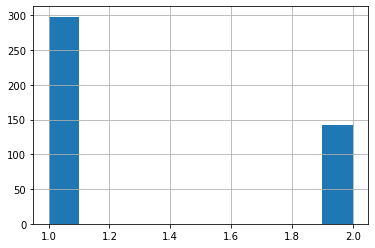

Region
AxesSubplot(0.125,0.125;0.775x0.755)


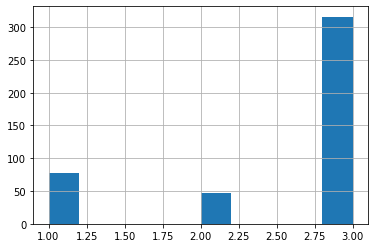

Fresh
AxesSubplot(0.125,0.125;0.775x0.755)


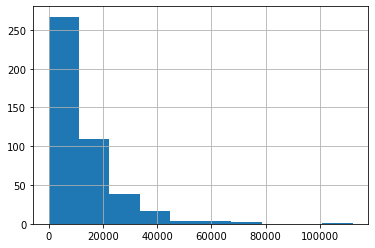

Milk
AxesSubplot(0.125,0.125;0.775x0.755)


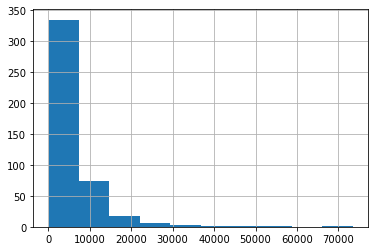

Grocery
AxesSubplot(0.125,0.125;0.775x0.755)


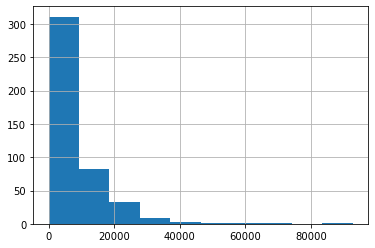

Frozen
AxesSubplot(0.125,0.125;0.775x0.755)


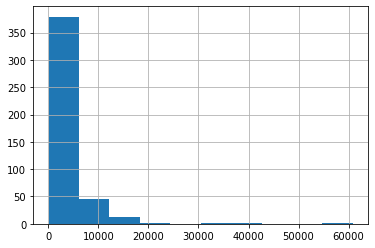

Detergents_Paper
AxesSubplot(0.125,0.125;0.775x0.755)


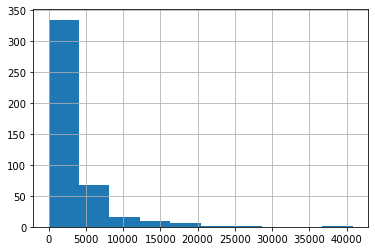

Delicassen
AxesSubplot(0.125,0.125;0.775x0.755)


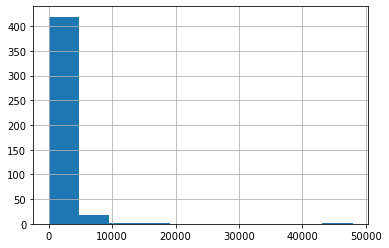

In [8]:
#individual distribution plots
for col in df.columns:
    print(col)
    print(df[col].hist())
    plt.show()

- `Channel` - like a marketing channel
- `Region` - could be like a geographical location
- The rest of the columns (`Fresh, Milk, Grocery, Frozen, Detergents_paper, Delicassen`) are sales units?

#### Cluster 1: `Fresh`and `Frozen`

In [9]:
#clustering on fresh and frozen
df = df[['Fresh', 'Frozen']]

In [10]:
np_array = df.values.astype("float32", copy = False)
#np_array[0:10]

In [11]:
#scale data
scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)

In [12]:
#make DBSCAN object
dbsc = DBSCAN(eps = .10, min_samples = 20).fit(np_array)

In [13]:
#add scaled col to original df
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df.columns)
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

 0    430
-1     10
Name: labels, dtype: int64


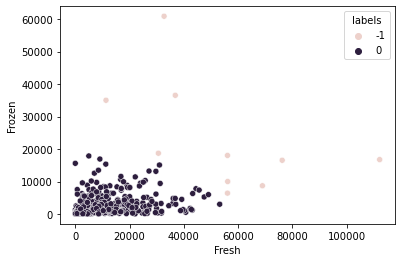

In [14]:
#grab the labels to plot results
labels = dbsc.labels_
df['labels'] = labels
print(df.labels.value_counts())

sns.scatterplot(df.Fresh, df.Frozen, hue=df.labels)
plt.show()

#### Cluster 2: `Detergents_paper` and `Delicassen`

In [15]:
#re-acquire df
df = pd.read_sql(sql, url, index_col="customer_id")

In [16]:
#clustering on Detergents_paper and Delicassen
df = df[['Detergents_Paper', 'Delicassen']]

In [17]:
np_array = df.values.astype("float32", copy = False)
#np_array[0:10]

In [18]:
#scale data
scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)

In [19]:
#make DBSCAN object
dbsc = DBSCAN(eps = .10, min_samples = 20).fit(np_array)

In [20]:
#add scaled col to original df
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df.columns)
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

 0    426
-1     14
Name: labels, dtype: int64


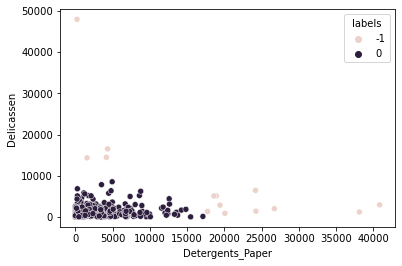

In [21]:
#grab the labels to plot results
labels = dbsc.labels_
df['labels'] = labels
print(df.labels.value_counts())

sns.scatterplot(df.Detergents_Paper, df.Delicassen, hue=df.labels)
plt.show()

#### Cluster 3: `Fresh` , `Grocery` and `Delicassen`

In [22]:
#re-acquire df
df = pd.read_sql(sql, url, index_col="customer_id")

In [23]:
#clustering on Fresh, Grocery, and Delicassen
df = df[['Fresh', 'Grocery', 'Delicassen']]

In [24]:
np_array = df.values.astype("float32", copy = False)
#np_array[0:10]

In [25]:
#scale data
scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)

In [26]:
#make DBSCAN object
dbsc = DBSCAN(eps = .10, min_samples = 20).fit(np_array)

In [27]:
#add scaled col to original df
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df.columns)
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

 0    421
-1     19
Name: labels, dtype: int64


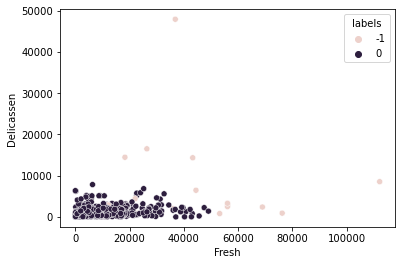

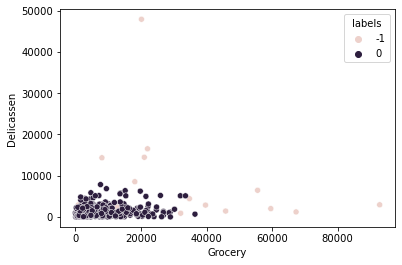

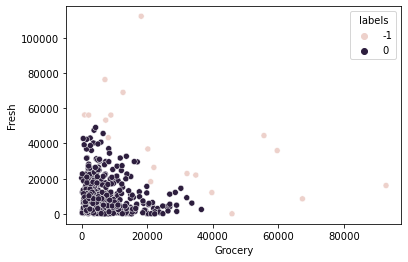

In [28]:
#grab the labels to plot results
labels = dbsc.labels_
df['labels'] = labels
print(df.labels.value_counts())

sns.scatterplot(df.Fresh, df.Delicassen, hue=df.labels)
plt.show()

sns.scatterplot(df.Grocery, df.Delicassen, hue=df.labels)
plt.show()

sns.scatterplot(df.Grocery, df.Fresh, hue=df.labels)
plt.show()

### 2. Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [29]:
#get connection by saving to a variable
url = get_connection("zillow")

#sql query saved to variable
sql = '''
SELECT parcelid, bedroomcnt AS bedrooms, calculatedfinishedsquarefeet AS square_feet, logerror, transactiondate
FROM properties_2017
JOIN predictions_2017 USING(parcelid)
WHERE propertylandusetypeid IN (260, 261, 263, 264, 265, 266, 273, 275, 276, 279)
AND year(transactiondate) = 2017;
'''

#use variables w/ pd.read_sql function and set customer_id as index
df = pd.read_sql(sql, url, index_col="parcelid")

#check out the df
df.head()

,bedrooms,square_feet,logerror,transactiondate
parcelid,,,,
14297519,4.0,3100.0,0.025595,2017-01-01
17052889,2.0,1465.0,0.055619,2017-01-01
14186244,3.0,1243.0,0.005383,2017-01-01
12177905,4.0,2376.0,-0.103410,2017-01-01
10887214,3.0,1312.0,0.006940,2017-01-01


In [30]:
#rows and columns
df.shape

(72299, 4)

In [31]:
#columns and dtypes info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72299 entries, 14297519 to 12826780
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedrooms         72299 non-null  float64
 1   square_feet      72106 non-null  float64
 2   logerror         72299 non-null  float64
 3   transactiondate  72299 non-null  object 
dtypes: float64(3), object(1)
memory usage: 2.8+ MB


In [32]:
#check nulls
df.isnull().sum()

bedrooms             0
square_feet        193
logerror             0
transactiondate      0
dtype: int64

In [33]:
#fill in missing values w/ 0
df = df.fillna(0)

In [34]:
df.isnull().sum()

bedrooms           0
square_feet        0
logerror           0
transactiondate    0
dtype: int64

In [35]:
#summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,72299.0,2.997317,1.034292,0.00000,2.00000,3.00000,4.000000,14.000000
square_feet,72299.0,1745.364901,935.886593,0.00000,1160.00000,1508.00000,2060.000000,21929.000000
logerror,72299.0,0.017041,0.169408,-4.65542,-0.02366,0.00668,0.038578,5.262999


bedrooms
AxesSubplot(0.125,0.125;0.775x0.755)


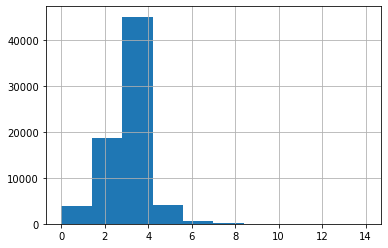

square_feet
AxesSubplot(0.125,0.125;0.775x0.755)


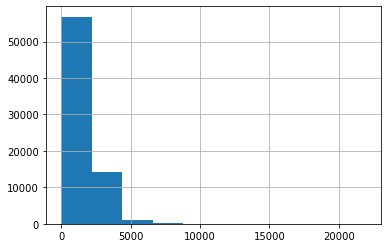

logerror
AxesSubplot(0.125,0.125;0.775x0.755)


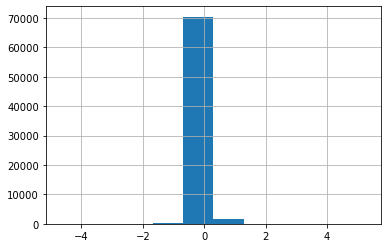

In [36]:
#individual distribution plots
for col in df.columns:
    if col != 'transactiondate':
        print(col)
        print(df[col].hist())
        plt.show()

In [37]:
# defines function to clean zillow data and return as a cleaned pandas DataFrame
def clean_zillow(df):
    '''
    clean_zillow will take one argument df, a pandas dataframe and will:
    convert data types to integers, 
    remove outliers from square_feet,
    drop any remaining nulls

    return: a single pandas dataframe with the above operations performed
    '''

    #convert dtypes to integers
    df.bedrooms = df.bedrooms.astype('int64')
    df.square_feet = df.square_feet.astype('int64')
            
    #remove outliers from square_feet
    #calculate IQR
    q1sf, q3sf = df.square_feet.quantile([.25, .75])
    iqrsf = q3sf - q1sf
            
    #calculate upper and lower bounds, outlier if above or below these
    uppersf = q3sf + (1.5 * iqrsf)
    lowersf = q1sf - (1.5 * iqrsf)
        
    #filter out the lower and upper outliers
    df = df[df.square_feet > lowersf]
    df = df[df.square_feet < uppersf]
    
    #drop any remaining nulls
    df = df.dropna()

    return df

In [38]:
df = clean_zillow(df)
print(df.shape)
df.head()

(68486, 4)


,bedrooms,square_feet,logerror,transactiondate
parcelid,,,,
14297519,4,3100,0.025595,2017-01-01
17052889,2,1465,0.055619,2017-01-01
14186244,3,1243,0.005383,2017-01-01
12177905,4,2376,-0.103410,2017-01-01
10887214,3,1312,0.006940,2017-01-01


In [39]:
#clustering on bedrooms and square_feet
df = df[['bedrooms', 'square_feet']]

In [40]:
np_array = df.values.astype("float32", copy = False)
#np_array[0:10]

In [41]:
#scale data
scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)

In [42]:
#make DBSCAN object
dbsc = DBSCAN(eps = .10, min_samples = 20).fit(np_array)

In [43]:
#add scaled col to original df
# Now, let's add the scaled value columns back onto the dataframe
#columns = list(df.columns)
#scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
#original_df = df.copy()

# Create a dataframe containing the scaled values
#scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
#df = df.merge(scaled_df, on=df.index)
#df = df.drop(columns=['key_0'])

 2    28727
 1    18597
 0    14496
 3     3328
 5     2511
 4      480
 7      283
-1       32
 6       32
Name: labels, dtype: int64


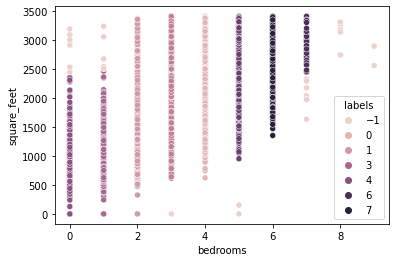

In [44]:
#grab the labels to plot results
labels = dbsc.labels_
df['labels'] = labels
print(df.labels.value_counts())

sns.scatterplot(df.bedrooms, df.square_feet, hue=df.labels)
plt.show()

### 3. Use curric data to detect anomalies (if there is still time to explore this).

In [45]:
#returns logs data from MySQL db as a pandas df
def get_logs():
    '''
    This function reads in the logs data from the Codeup db
    and returns a pandas DataFrame with all columns.
    '''
    #create SQL query
    sql_query = 'SELECT * FROM logs LEFT JOIN cohorts ON cohorts.id = logs.cohort_id'
    
    #read in dataframe from Codeup db
    df = pd.read_sql(sql_query, get_connection('curriculum_logs'))
    
    return df

In [46]:
df = get_logs()
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0


In [47]:
#rows and columns
df.shape

(900223, 15)

In [48]:
#columns and dtypes info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        900223 non-null  object 
 1   time        900223 non-null  object 
 2   path        900222 non-null  object 
 3   user_id     900223 non-null  int64  
 4   cohort_id   847330 non-null  float64
 5   ip          900223 non-null  object 
 6   id          847330 non-null  float64
 7   name        847330 non-null  object 
 8   slack       847330 non-null  object 
 9   start_date  847330 non-null  object 
 10  end_date    847330 non-null  object 
 11  created_at  847330 non-null  object 
 12  updated_at  847330 non-null  object 
 13  deleted_at  0 non-null       object 
 14  program_id  847330 non-null  float64
dtypes: float64(3), int64(1), object(11)
memory usage: 103.0+ MB


In [49]:
#check nulls
df.isnull().sum()

date               0
time               0
path               1
user_id            0
cohort_id      52893
ip                 0
id             52893
name           52893
slack          52893
start_date     52893
end_date       52893
created_at     52893
updated_at     52893
deleted_at    900223
program_id     52893
dtype: int64

In [50]:
#combine date and time columns, convert to datetime and set as index
df["datetime"] = df["date"] + ' '+ df["time"]
df['datetime'] = pd.to_datetime(df.datetime)
df = df.set_index('datetime')

#drop original date and time columns
df.drop(columns=['date', 'time'], inplace = True)

#drop unnecessary / repeated  cols
df = df.drop(columns = ['id', 'slack', 'deleted_at', 'program_id'])

#filling remaining nulls
df = df.fillna(0)

#specify easley cohort only
df = df[df.name == 'Easley']

#creating hour col
df['hour'] = df.index.hour

print(df.shape)
df.isnull().sum()

(14715, 10)


path          0
user_id       0
cohort_id     0
ip            0
name          0
start_date    0
end_date      0
created_at    0
updated_at    0
hour          0
dtype: int64

In [51]:
#clustering on Easley and hour
df = df[['user_id', 'hour']]

In [52]:
np_array = df.values.astype("float32", copy = False)
#np_array[0:10]

In [53]:
#scale data
scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)

In [54]:
#make DBSCAN object
dbsc = DBSCAN(eps = .10, min_samples = 20).fit(np_array)

In [55]:
#add scaled col to original df
# Now, let's add the scaled value columns back onto the dataframe
#columns = list(df.columns)
#scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
#original_df = df.copy()

# Create a dataframe containing the scaled values
#scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
#df = df.merge(scaled_df, on=df.index)
#df = df.drop(columns=['key_0'])

0    13907
1      808
Name: labels, dtype: int64


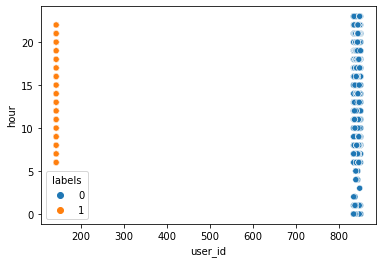

In [56]:
#grab the labels to plot results
labels = dbsc.labels_
df['labels'] = labels
print(df.labels.value_counts())

sns.scatterplot(df.user_id, df.hour, hue=df.labels)
plt.show()